# On similarity measures for image registration
_María Camila Vásquez Correa_

## Necessary Packages

In [1]:
import numpy as np
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
import skimage

In [2]:
# Plot parameters
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [3]:
# Data loading
t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_data()
t2_img = nib.load('mni_icbm152_t2_tal_nlin_asym_09a.nii')
t2_data = t2_img.get_data()

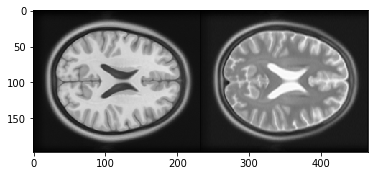

In [4]:
# Slice of the Nifti image
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
plt.imshow(np.hstack((t1_slice, t2_slice)))
plt.show()

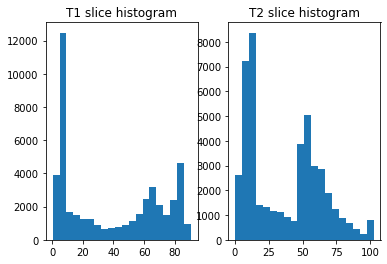

In [5]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(t1_slice.ravel(), bins=20)
axes[0].set_title('T1 slice histogram')
axes[1].hist(t2_slice.ravel(), bins=20)
axes[1].set_title('T2 slice histogram')
plt.show()

0.7870798551095302

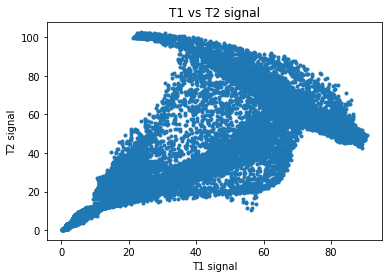

In [6]:
plt.plot(t1_slice.ravel(), t2_slice.ravel(), '.')
plt.xlabel('T1 signal')
plt.ylabel('T2 signal')
plt.title('T1 vs T2 signal')
np.corrcoef(t1_slice.ravel(), t2_slice.ravel())[0, 1]

Text(0.5, 1.0, 'T2 slice')

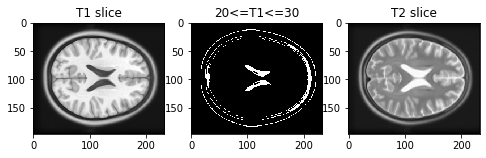

In [7]:
# Array that is True if T1 signal >= 20, <= 30, False otherwise
t1_20_30 = (t1_slice >= 20) & (t1_slice <= 30)
# Show T1 slice, mask for T1 between 20 and 30, T2 slice
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(t1_slice)
axes[0].set_title('T1 slice')
axes[1].imshow(t1_20_30)
axes[1].set_title('20<=T1<=30')
axes[2].imshow(t2_slice)
axes[2].set_title('T2 slice')

In [8]:
hist_2d, x_edges, y_edges = np.histogram2d(
    t1_slice.ravel(),
    t2_slice.ravel(),
    bins=20)

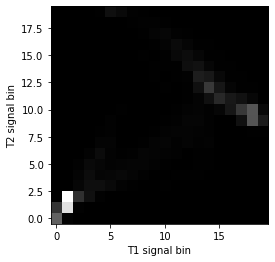

In [9]:
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')
plt.show()

Text(0, 0.5, 'T2 signal bin')

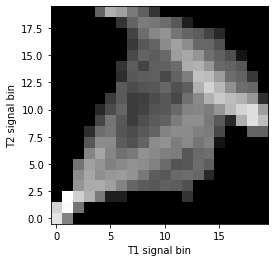

In [10]:
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

## Mutual information

In [11]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

mutual_information(hist_2d)

1.3399511058289812

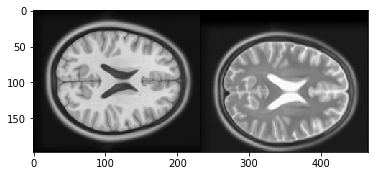

In [12]:
t2_slice_moved = np.zeros(t2_slice.shape)
t2_slice_moved[15:, :] = t2_slice[:-15, :]
plt.imshow(np.hstack((t1_slice, t2_slice_moved)))
plt.show()

/home/camivasz/anaconda3/envs/practica/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


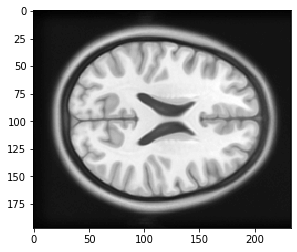

In [13]:
def blur_image(Image_in, epsilon):
    Image = Image_in.copy()
    n = int(Image.size/epsilon)
    for i in range(1,n):
        b = [(Image <= epsilon*i) & (Image >= epsilon*(i-1))]
        Image[b] = 0.5*(epsilon*i + epsilon*(i-1))
    return Image
plt.imshow(blur_image(t1_slice,1))
plt.show()

In [14]:
t1_b = blur_image(t1_slice,1)
t2_b = blur_image(t2_slice,1)

/home/camivasz/anaconda3/envs/practica/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


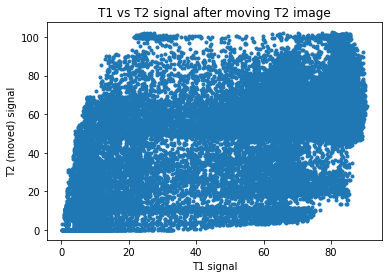

In [15]:
plt.plot(t1_slice.ravel(), t2_slice_moved.ravel(), '.')
plt.xlabel('T1 signal')
plt.ylabel('T2 (moved) signal')
plt.title('T1 vs T2 signal after moving T2 image')
plt.show()

In [16]:
hist_2d_moved, x_edges, y_edges = np.histogram2d(
    t1_slice.ravel(),
    t2_slice_moved.ravel(),
    bins=20)

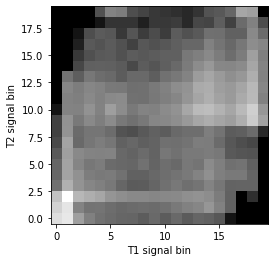

In [17]:
hist_2d_moved_log = np.zeros(hist_2d_moved.shape)
non_zeros = hist_2d_moved != 0
hist_2d_moved_log[non_zeros] = np.log(hist_2d_moved[non_zeros])
plt.imshow(hist_2d_moved_log.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')
plt.show()

In [18]:
mutual_information(hist_2d_moved)

0.4577827377824529

## Shannon Joint Entropy

In [19]:
entropy_T1 = skimage.measure.shannon_entropy(t1_slice)
entropy_T2 = skimage.measure.shannon_entropy(t2_slice)
joint_entropy = entropy_T1 + entropy_T2 - mutual_information(hist_2d)

In [20]:
joint_entropy

26.9976311949709

## Sum of squared differences

In [21]:
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

In [22]:
mse(t1_slice, t2_slice)

376.9846047746162

## Correlation coefficient

In [23]:
def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

In [24]:
correlation_coefficient(t1_slice, t2_slice)

0.7870798551095303

## Correlation ratio

In [25]:
# Flat the vector
t1 = t1_slice.flatten()
t2 = t2_slice.flatten()

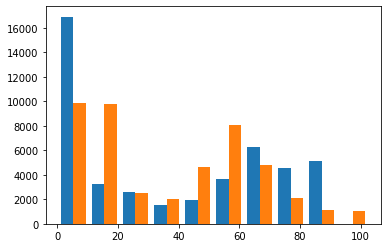

In [26]:
plt.hist([t1,t2])
plt.show()

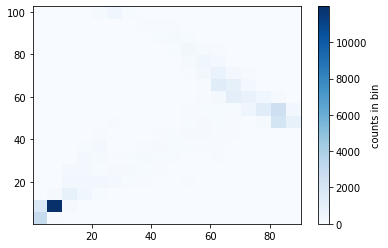

In [27]:
plt.hist2d(t1, t2, bins=int(np.max(t1)/5), cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')

In [80]:
def CR(t1,t2,epsilon):
    # New data
    X = np.arange(epsilon*0.5, int(np.max(t1)),epsilon)
    Y = np.arange(epsilon*0.5, int(np.max(t2)),epsilon)
    def compress(AA,BB,epsilon):
        sx = len(X)
        sy = len(Y)
        a = np.zeros((sx, sy))
        for i in range(1,sx):
            for j in range(1,sy):
                b = [(AA <= epsilon*i) & (AA > epsilon*i-1) & (BB <= epsilon*j) & (BB > epsilon*j-1)]
                a[i,j] = np.sum(b)
        return a
    # Generation of the probability functions
    dens = compress(t1,t2,epsilon)
    marginal_x = np.sum(dens, axis = 1)
    marginal_y = np.sum(dens, axis = 0)
    def conditional_variance_x(y):
        py = marginal_y[int(y/epsilon + 0.5)-1]
        if py == 0:
            return 0
        else:
            left = X**2*dens[:,int(y/epsilon + 0.5)-1]/py
            right = X*dens[:,int(y/epsilon + 0.5)-1]/py
            return np.sum(left) - np.sum(right)**2
    def conditional_variance_y(x):
        px = marginal_x[int(x/epsilon + 0.5)-1]
        if px == 0:
            return 0
        else:
            left = Y**2*dens[int(x/epsilon + 0.5)-1,:]/px
            right = Y*dens[int(x/epsilon + 0.5)-1,:]/px
            return np.sum(left) - np.sum(right)**2
    var_x = np.var(X)
    su = 0
    for y in Y:
        su += conditional_variance_x(y)
    left = su/var_x
    var_y = np.var(Y)
    su = 0
    for x in X:
        su += conditional_variance_y(x)
    right = su/var_y
    return left + right

In [81]:
CR(t1,t2,45)

0.0

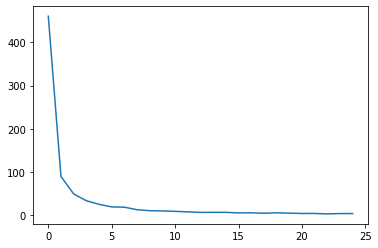

In [69]:
plt.plot([CR(t1,t2,x) for x in np.linspace(0.1,10,25)])
plt.show()